The goal of my project is to examine the factors driving complaints about syringe litter in New York City.

In [247]:
# Install libraries
!pip install geodatasets
!pip install pysal

# Import libraries
from datetime import datetime
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import randint
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Data cleaning and exploratory data analysis

## Syringe complaints

In [2]:
# Download the 311 complaints about syringes
syringe_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?descriptor=Syringes&$limit=50000')
syringe_complaints.head(2)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,64749028,2025-04-24T17:32:25.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10468.0,2715 GRAND CONCOURSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.867480,-73.893320,"\n, \n(40.867480059467404, -73.89332000002392)"
1,64732588,2025-04-23T23:24:45.000,2025-04-24T13:07:15.000,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10038.0,245 WATER STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.708033,-74.002363,"\n, \n(40.708033011840726, -74.0023625107346)"


In [3]:
# Convert created_date from an object to a date
syringe_complaints['created_date'] = pd.to_datetime(syringe_complaints['created_date'])

# Rename 'created_date' to 'created_datetime'
syringe_complaints = syringe_complaints.rename(columns = {'created_date': 'created_datetime'})

# Extract date, month, and year from 'created_datetime'
syringe_complaints['created_date'] = syringe_complaints['created_datetime'].dt.date
syringe_complaints['created_month'] = syringe_complaints['created_datetime'].dt.month
syringe_complaints['created_year'] = syringe_complaints['created_datetime'].dt.year

In [4]:
# Drop duplicate complaints (same date, latitude, and longitude)
syringe_complaints = syringe_complaints.drop_duplicates(subset = ['created_date', 'latitude', 'longitude'])
syringe_complaints.reset_index(drop = True, inplace = True)

In [5]:
# Look for missing values
syringe_complaints.isna().sum()

,0
unique_key,0
created_datetime,0
closed_date,7
agency,0
agency_name,0
complaint_type,0
descriptor,0
location_type,0
incident_zip,1
incident_address,1


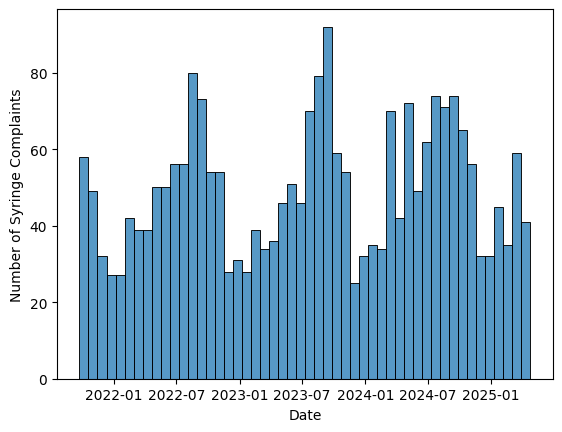

In [6]:
# Make a histogram to show the frequency of syringe complaints
ax = sns.histplot(data=syringe_complaints['created_datetime'], bins = 50)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Syringe Complaints')
plt.show()

Interesting finding: syringe complaints follow a cyclical trend, peaking at similar times each year!

In [7]:
# Look at the earliest and latest date
print(syringe_complaints['created_datetime'].min())
print(syringe_complaints['created_datetime'].max())

2021-09-22 09:01:47
2025-04-24 17:32:25


In [8]:
# Keep only complaints from 2022 to 2024 to make later analyses easier
syringe_complaints = syringe_complaints[(syringe_complaints['created_year']>=2022) & (syringe_complaints['created_year']<=2024)]

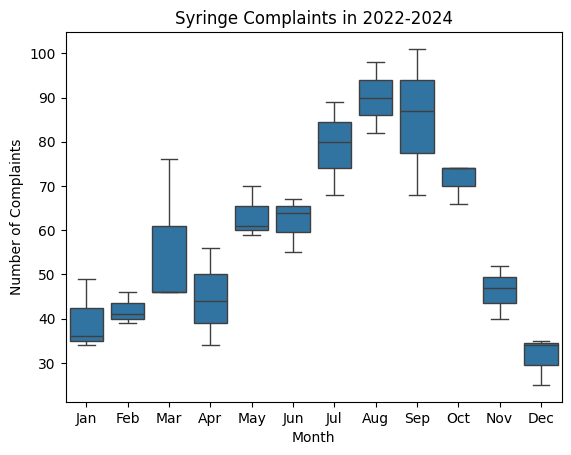

In [9]:
# Make a boxplot to show the number of syringe complaints each month
ax = sns.boxplot(data = syringe_complaints.groupby(['created_year', 'created_month'])['created_datetime'].agg(complaint_count = 'count').reset_index(),
                 x = 'created_month',
                 y = 'complaint_count')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Complaints')
plt.title('Syringe Complaints in 2022-2024')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

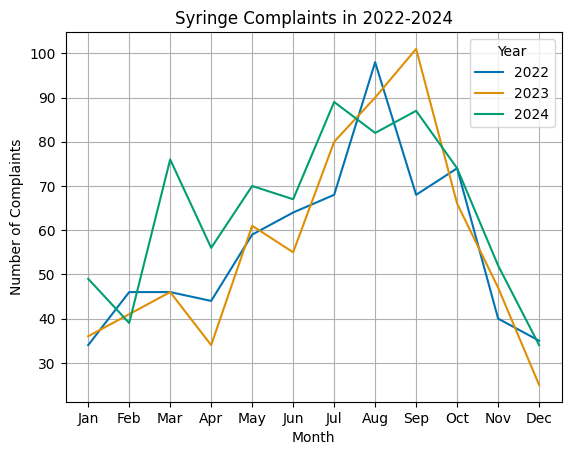

In [10]:
# Make a lineplot of the number of syringe complaints each month, with a different line pear year
ax = sns.lineplot(data = syringe_complaints.groupby(['created_year', 'created_month'])['created_datetime'].agg(complaint_count = 'count').reset_index(),
                  x = 'created_month',
                  y = 'complaint_count',
                  hue = 'created_year',
                  palette = 'colorblind')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Syringe Complaints in 2022-2024')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

## Other types of 311 complaints

In [11]:
# Download all of the 311 complaints in 2022, 2023, and 2024
# To limit the size of the download, select only unique_key, created_date, complaint_type, descriptor, longitude, and latitude
all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')
all_311_complaints.head(2)

<ipython-input-11-6ce3a10b2812>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')


,unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude
0,53467609,2022-02-25T00:42:00.000,Water System,Hydrant Defective (WC2),116 WEST 31 STREET,10001.0,-73.989920,40.748208
1,53467474,2022-02-25T08:03:27.000,Graffiti,Graffiti,210 JAMAICA AVENUE,11207.0,-73.892451,40.680499


In [12]:
# Convert created_date from an object to a date
all_311_complaints['created_date'] = pd.to_datetime(all_311_complaints['created_date'])

# Rename 'created_date' to 'created_datetime'
all_311_complaints = all_311_complaints.rename(columns = {'created_date': 'created_datetime'})

# Extract date, month, and year from 'created_datetime'
all_311_complaints['created_date'] = all_311_complaints['created_datetime'].dt.date
all_311_complaints['created_month'] = all_311_complaints['created_datetime'].dt.month
all_311_complaints['created_year'] = all_311_complaints['created_datetime'].dt.year

In [13]:
# Remove duplicate complaints
all_311_complaints.drop_duplicates(subset = ['created_date', 'complaint_type', 'descriptor', 'incident_address', 'incident_zip', 'latitude', 'longitude'])
all_311_complaints.reset_index(drop = True, inplace = True)

In [14]:
# Group the 311 complaints by month and year
# Then count the complaints and just the syringe-related complaints
all_311_complaints_monthly = all_311_complaints.groupby(['created_year', 'created_month']).agg(
    all_complaints = ('descriptor', 'count'),
    syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()))

# Divide the syringe-related complaints by the total complaints
all_311_complaints_monthly['syringes/all (%)'] = 100 * all_311_complaints_monthly['syringe_complaints'] / all_311_complaints_monthly['all_complaints']
all_311_complaints_monthly.head(2)

all_complaints  syringe_complaints  \
created_year created_month                                       
2022         1                      272566                  34   
             2                      239223                  48   

                            syringes/all (%)  
created_year created_month                    
2022         1                      0.012474  
             2                      0.020065

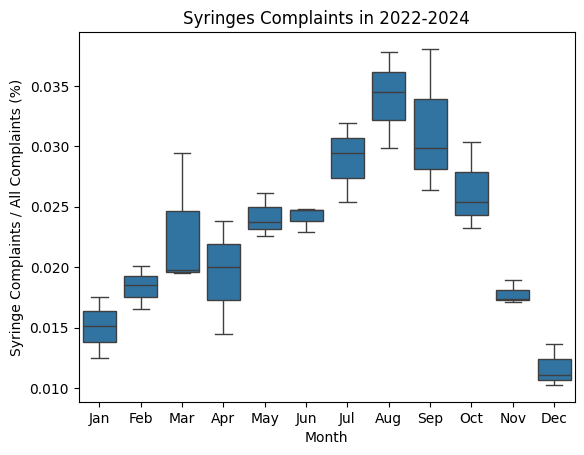

In [15]:
# Make a boxplot for syringes/all
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax = sns.boxplot(data = all_311_complaints_monthly,
                 x = 'created_month',
                 y = 'syringes/all (%)',
                 order = order)
ax.set_xlabel('Month')
ax.set_ylabel('Syringe Complaints / All Complaints (%)')
plt.title('Syringes Complaints in 2022-2024')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## Geographic distribution

In [16]:
# Drop columns that won't be needed
all_311_complaints = all_311_complaints.drop(columns = ['incident_address', 'incident_zip'])

In [17]:
all_311_complaints

,unique_key,created_datetime,complaint_type,descriptor,longitude,latitude,created_date,created_month,created_year
0,53467609,2022-02-25 00:42:00,Water System,Hydrant Defective (WC2),-73.989920,40.748208,2022-02-25,2,2022
1,53467474,2022-02-25 08:03:27,Graffiti,Graffiti,-73.892451,40.680499,2022-02-25,2,2022
2,53467523,2022-02-26 01:14:52,Illegal Parking,Blocked Hydrant,-73.919152,40.772811,2022-02-26,2,2022
3,53467647,2022-02-25 12:52:00,Water System,Leak (Use Comments) (WA2),-74.201313,40.554363,2022-02-25,2,2022
4,53468161,2022-02-25 07:52:55,Abandoned Vehicle,With License Plate,-73.908342,40.721084,2022-02-25,2,2022
...,...,...,...,...,...,...,...,...,...
9853708,53467479,2022-02-25 08:55:53,Graffiti,Graffiti,-73.893428,40.662412,2022-02-25,2,2022
9853709,53468263,2022-02-25 14:09:51,Abandoned Vehicle,With License Plate,-73.985245,40.639984,2022-02-25,2,2022
9853710,53467646,2022-02-25 11:51:00,Street Light Condition,Street Light Out,-73.878253,40.702147,2022-02-25,2,2022
9853711,53467473,2022-02-25 08:32:06,Graffiti,Graffiti,-73.905484,40.670476,2022-02-25,2,2022


In [18]:
# Drop rows that do not have latitude and longitude data
all_311_complaints = all_311_complaints.dropna(subset = ['latitude', 'longitude'], how = 'any', ignore_index = True)

In [19]:
# Convert all_311_complaints into a GeoDataFrame in the NAD83 / New York Long Island (ftUS) coordinate reference system
all_311_complaints = gpd.GeoDataFrame(all_311_complaints,
                                      geometry = gpd.points_from_xy(all_311_complaints.longitude, all_311_complaints.latitude),
                                      crs = 'EPSG:4326')
all_311_complaints = all_311_complaints.to_crs(2263)

In [20]:
# Load map of NYC for plotting, CRS = 2263 (NAD83 / New York Long Island (ftUS))
nyc = gpd.read_file(geodatasets.get_path('nybb'))

Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


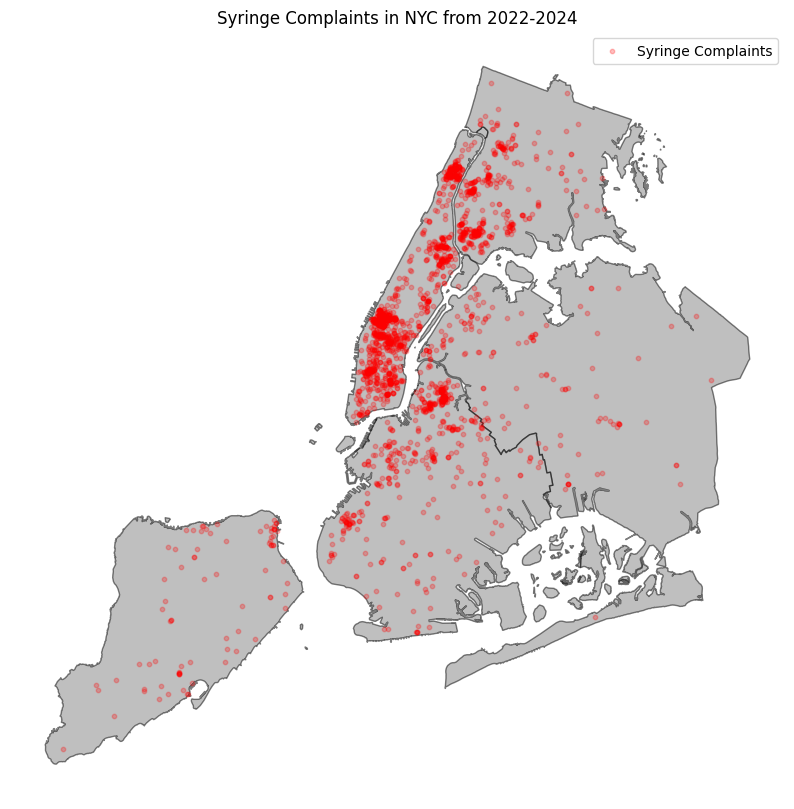

In [21]:
# Plot the syringe complaints on a map of NYC
ax = nyc.plot(figsize = (10, 10), alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints
all_311_complaints[all_311_complaints['descriptor']=='Syringes'].plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')

# Format the plot
ax.set_axis_off()
ax.legend(['Syringe Complaints'])
plt.title('Syringe Complaints in NYC from 2022-2024')
plt.show()

In [22]:
# Download the sharps dropoff site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


In [23]:
# Keep only the sharps dropoff sites
dropoff_sites = dropoff_sites[dropoff_sites['site_type'] == 'SYRINGE/SHARPS Drop-off']

# Keep only the relevant columns in dropoff_sites
dropoff_sites = dropoff_sites[['sitename', 'days_hours', 'latitude', 'longitude']]
dropoff_sites = dropoff_sites.reset_index(drop = True)

In [24]:
# Look at the values in the 'days_hours' column
dropoff_sites['days_hours'].value_counts()

,count
days_hours,
24/7,26
Monday-Friday 9am-5pm,19
9am-5pm,14
Monday-Friday 8am-4pm,7
10am-4pm,4
...,...
Monday-Thursday 10am-3pm,1
Monday-Sunday 11am-1pm,1
"Monday, Tuesday, Friday 9am-5pm; Wednesday 10AM-5PM; Thursday 9AM-7PM",1


In [25]:
# Use Google's Gemini LLM to parse the 'days_hours' column into something more quantifiable

# Import the necessary libraries
from IPython.display import HTML, Markdown, display
from google.colab import userdata
from google.api_core import retry
from google import genai
from pydantic import BaseModel

# Get the Google API key
GOOGLE_API_KEY = userdata.get('google_api_key')

# Handle errors
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Initialize the genAI client
client = genai.Client(api_key=GOOGLE_API_KEY)

# Define what the LLM's response should look like
class Response(BaseModel):
  logical: str
  hours_per_month: int

# For each dropoff site, ask whether the dropoff hours make sense
# If so, calculate the hours the site is open in a 28-day month
for i in range(len(dropoff_sites)):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      contents=f'''The site hours are {dropoff_sites.loc[i, 'days_hours']}. Does this make logical sense, Yes or No?
      How many hours in a 28-day month is the site open?''',
      config={'response_mime_type': 'application/json',
              'response_schema': list[Response]})

  # Save the calculated hours
  if response.parsed[0].logical == 'Yes':
    dropoff_sites.loc[i, 'hours_per_month'] = response.parsed[0].hours_per_month
  else:
    dropoff_sites.loc[i, 'hours_per_month'] = np.nan

  # Track progress
  if i % 50 == 0:
    print(f'Progress: {i} rows')

Progress: 0 rows
Progress: 50 rows
Progress: 100 rows
Progress: 150 rows


In [26]:
dropoff_sites.head(2)

,sitename,days_hours,latitude,longitude,hours_per_month
0,North Central Bronx Hospital,24/7,40.880432,-73.881204,672.0
1,Union Plaza Care Center,10am-2pm,40.767323,-73.826924,112.0


In [27]:
# Turn dropoff_sites into a GeoDataFrame
dropoff_sites = gpd.GeoDataFrame(dropoff_sites,
                                 geometry = gpd.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude),
                                 crs = 'EPSG:4326')
dropoff_sites = dropoff_sites.to_crs(2263)

In [28]:
# Export dropoff_sites as a .pkl file
dropoff_sites.to_pickle('dropoff_sites.pkl')

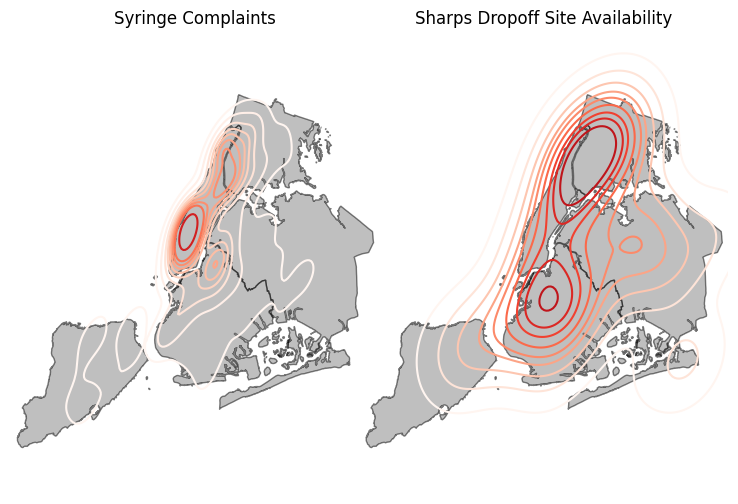

In [29]:
# Plot dropoff locations and syringe locations side by side
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# Plot syringe complaints on one subplot
subplot1 = nyc.plot(ax = axes[0], alpha = 0.5, color = 'gray', edgecolor = 'k')
sns.kdeplot(x = all_311_complaints[all_311_complaints['descriptor']=='Syringes'].geometry.x,
            y = all_311_complaints[all_311_complaints['descriptor']=='Syringes'].geometry.y,
            cmap = 'Reds',
            ax=axes[0])

# Plot dropoff sites on the other subplot
subplot2 = nyc.plot(ax = axes[1], alpha = 0.5, color = 'gray', edgecolor = 'k')
sns.kdeplot(x = dropoff_sites.geometry.x, y = dropoff_sites.geometry.y,
            weights = dropoff_sites['hours_per_month']/672,
            cmap = 'Reds',
            ax=axes[1])

# Format the plot
subplot1.set_axis_off()
subplot2.set_axis_off()

# Set x and y limits
axes[0].set_xlim(0.91e6, 1.07e6)
axes[0].set_ylim(100000, 300000)
axes[1].set_xlim(0.91e6, 1.07e6)
axes[1].set_ylim(100000, 300000)

# Title each subplot
axes[0].set_title('Syringe Complaints')
axes[1].set_title('Sharps Dropoff Site Availability')
plt.subplots_adjust(wspace = -0.4)
plt.show()

# Feature engineering

In [30]:
# Load neighborhood tabulation area (NTA) data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip -O nta.zip
!unzip nta.zip

nta = gpd.read_file('/content/nynta2020_25a/nynta2020.shp')
nta = nta.to_crs(2263)
nta.head(2)

--2025-04-26 23:22:25--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 104.67.198.65, 2600:1408:c400:78a::1500, 2600:1408:c400:781::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|104.67.198.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 989198 (966K) [application/zip]
Saving to: ‘nta.zip’

nta.zip             100%[===================>] 966.01K  --.-KB/s    in 0.1s    

2025-04-26 23:22:25 (9.25 MB/s) - ‘nta.zip’ saved [989198/989198]

Archive:  nta.zip
  inflating: nynta2020_25a/nynta2020.shp  
  inflating: nynta2020_25a/nynta2020.dbf  
  inflating: nynta2020_25a/nynta2020.shx  
  inflating: nynta2020_25a/nynta2020.prj  
  inflating: nynta2020_25a/nynta2020.shp.xml  


,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,2.885431e+07,"POLYGON ((995851.915 203199.332, 995969.192 20..."


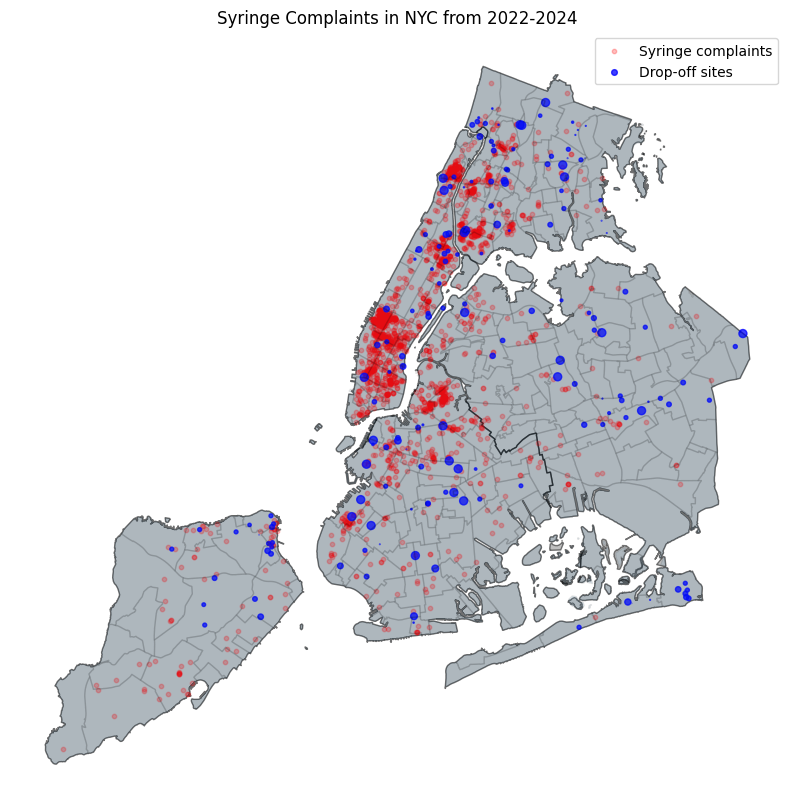

In [31]:
# Plot the syringe complaints, dropoff sites, and NTAs on a map of NYC
ax = nyc.plot(figsize = (10, 10), alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints
all_311_complaints[all_311_complaints['descriptor']=='Syringes'].plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')

# Plot the dropoff sites
dropoff_sites.plot(ax = ax, markersize = dropoff_sites['hours_per_month']*0.05, alpha = 0.75, color = 'blue')

# Plot the NTAs
nta.plot(ax = ax, edgecolor = 'k', alpha = 0.1)

# Format the plot
ax.set_axis_off()
ax.legend(['Syringe complaints', 'Drop-off sites'])
plt.title('Syringe Complaints in NYC from 2022-2024')
plt.show()

In [32]:
# Spatial join all_311_complaints and nta
all_311_complaints = all_311_complaints.sjoin(nta[['NTA2020', 'geometry']], how = 'left')

In [33]:
# Save all_311_complaints as a .pkl file
all_311_complaints.to_pickle('all_311_complaints.pkl')

In [34]:
# Group the complaints by NTA
# Test for correlations between syringe complaints and other categories of complaints, normalizing them to total complaints
all = all_311_complaints.groupby('NTA2020').agg(all = ('unique_key', 'count')).sort_values(by = 'NTA2020').values
syringes = all_311_complaints.groupby('NTA2020').agg(syringes = ('descriptor', lambda x: (x == 'Syringes').sum())).sort_values(by = 'NTA2020').values

for complaint in list(set(all_311_complaints['complaint_type'])):
  other = all_311_complaints.groupby('NTA2020').agg(other = ('complaint_type', lambda x: (x == complaint).sum())).sort_values(by = 'NTA2020').values
  test_corr = stats.pearsonr(syringes/all, other/all)

  # Print the categories with a correlation coefficient greater than 0.4 and a p-value less than 0.05
  if (test_corr[0] > 0.4) & (test_corr[1] < 0.05):
    print(complaint, test_corr)

Panhandling PearsonRResult(statistic=array([0.51805447]), pvalue=array([2.14952994e-19]))
Encampment PearsonRResult(statistic=array([0.51254699]), pvalue=array([5.93171004e-19]))
Bench PearsonRResult(statistic=array([0.40016134]), pvalue=array([1.70266931e-11]))
Homeless Person Assistance PearsonRResult(statistic=array([0.40412799]), pvalue=array([1.02839595e-11]))


In [176]:
# Group all_311_complaints by NTA and calculate the following:
# All complaints
# Syringe complaints
# Encampment complaints
# Bench complaints
# Panhandling complaints
# Homeless person assistance complaints
complaints_by_nta = all_311_complaints.groupby('NTA2020').agg(all_complaints = ('unique_key', 'count'),
                                                              syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                              encampment_complaints = ('complaint_type', lambda x: (x == 'Encampment').sum()),
                                                              bench_complaints = ('complaint_type', lambda x: (x == 'Bench').sum()),
                                                              panhandling_complaints = ('complaint_type', lambda x: (x == 'Panhandling').sum()),
                                                              homeless_assistance_complaints = ('complaint_type', lambda x: (x == 'Homeless Person Assistance').sum()))
complaints_by_nta.reset_index(inplace = True)

In [177]:
# Divide each category by all_complaints
complaints_by_nta['syringes/all (%)'] = 100 * complaints_by_nta['syringe_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['encampments/all (%)'] = 100 * complaints_by_nta['encampment_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['benches/all (%)'] = 100 * complaints_by_nta['bench_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['panhandling/all (%)'] = 100 * complaints_by_nta['panhandling_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['homeless assistance/all (%)'] = 100 * complaints_by_nta['homeless_assistance_complaints'] / complaints_by_nta['all_complaints']

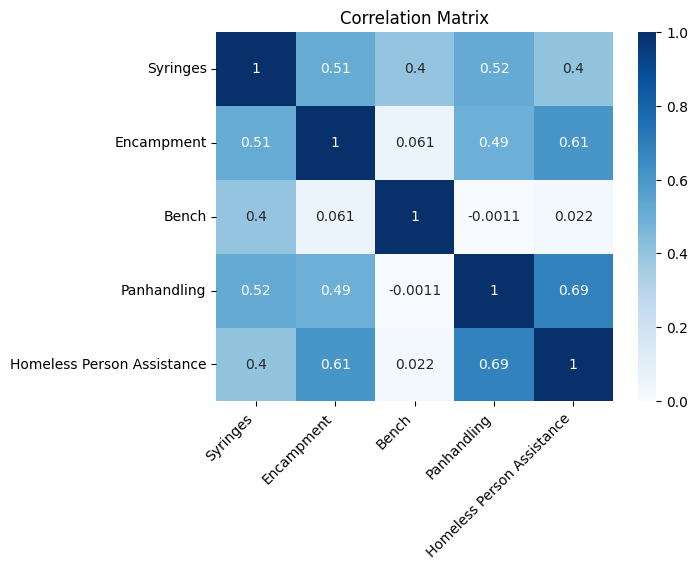

In [178]:
# Plot the correlation matrix between syringe complaints and the other complaint categories, divided by all complaints
fig, ax = plt.subplots()
sns.heatmap(complaints_by_nta[['syringes/all (%)',
                               'encampments/all (%)',
                               'benches/all (%)',
                               'panhandling/all (%)',
                               'homeless assistance/all (%)']].corr(),
            cmap = 'Blues', annot = True)
ax.set_title('Correlation Matrix')
ax.set_xticklabels(['Syringes', 'Encampment', 'Bench', 'Panhandling', 'Homeless Person Assistance'], rotation = 45, ha = 'right')
ax.set_yticklabels(['Syringes', 'Encampment', 'Bench', 'Panhandling', 'Homeless Person Assistance'])
plt.show()

In [179]:
# Add separate columns for NTAType
# Combining 5 (Rikers Island) with 6 ("Other Special Areas")
nta['residential'] = np.where(nta['NTAType']=='0', 1, 0)
nta['cemetery'] = np.where(nta['NTAType']=='7', 1, 0)
nta['airport'] = np.where(nta['NTAType']=='8', 1, 0)
nta['park'] = np.where(nta['NTAType']=='9', 1, 0)
nta['other'] = np.where((nta['NTAType']=='5') | (nta['NTAType']=='6'), 1, 0)

In [180]:
# Convert NTA area to square miles
nta['area_sq_mi'] = nta['Shape_Area'] / 2.788e+7

In [181]:
# Join complaints_by_nta and nta
complaints_by_nta = complaints_by_nta.merge(nta[['NTA2020', 'area_sq_mi', 'residential', 'cemetery', 'airport', 'park', 'other']], on = 'NTA2020')

In [182]:
# For each NTA, generate 100 random points
nta_random_points = gpd.GeoDataFrame()
nta_random_points['NTA2020'] = nta['NTA2020']
nta_random_points['random_points'] = nta['geometry'].sample_points(100, method='uniform', rng = 212)
nta_random_points = nta_random_points.set_index('NTA2020')
nta_random_points = nta_random_points['random_points'].explode(ignore_index = False).reset_index()

# For each random point, calculate the distance to the nearest dropoff site
nta_random_points['nearest_dropoff_dist_ft'] = nta_random_points['random_points'].apply(lambda x: dropoff_sites.distance(x).min()).round(0)
nta_random_points['nearest_dropoff_dist_mi'] = nta_random_points['nearest_dropoff_dist_ft'] / 5280

# For each random point, calculate the distance to Times Square
times_square = pd.DataFrame({'longitude': [-73.985130], 'latitude': [40.758896]})
times_square = gpd.points_from_xy(times_square.longitude, times_square.latitude, crs = 'EPSG:4326').to_crs(epsg=2263)
nta_random_points['times_square_dist_ft'] = nta_random_points['random_points'].apply(lambda x: times_square.distance(x).mean()).round(0)
nta_random_points['times_square_dist_mi'] = nta_random_points['times_square_dist_ft'] / 5280

# Group nta_random_points to get the average for each NTA
nta_random_points = nta_random_points.groupby('NTA2020').agg(nearest_dropoff_dist_mi = ('nearest_dropoff_dist_mi', 'mean'),
                                                             times_square_dist_mi = ('times_square_dist_mi', 'mean')).reset_index()

In [183]:
# Join complaints_by_nta and nta_random_points
complaints_by_nta = complaints_by_nta.merge(nta_random_points[['NTA2020', 'nearest_dropoff_dist_mi', 'times_square_dist_mi']], on = 'NTA2020')

<Axes: >

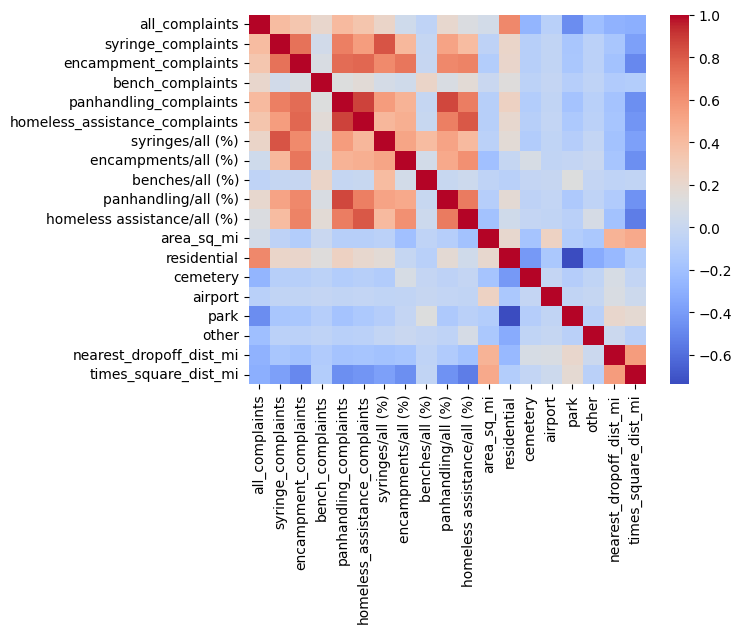

In [184]:
# View the correlation matrix
sns.heatmap(complaints_by_nta[complaints_by_nta.columns[1:]].corr(), cmap = 'coolwarm')

We would expect to see a correlation between syringe complaints and the distance to the nearest sharps dropoff site. However, that does not really appear to be the case. There are several possible explanations for this:
* We need to normalize the complaints data differently, e.g., complaints per capita.
*   We are not taking into account the opening hours of the dropoff sites, so nearest_dropoff_dist_ft is not a real measure of sharps dropoff site availability. Similarly, there could be other barriers preventing people from going to dropoff sites even if they are nearby and open.
*   Syringe complaints are not a great measure of the amount of syringe litter, but rather a measure of how bothered people are about it. Therefore, the number of 311 complaints might correlate more with something like wealth inequality.

I will add some features from the American Community Survey.

From the Demographic data:
* Pop_1E: the population estimate

From the Economic data:
* CvLFUEm1P: the percent of the labor force that is unemployed
* MdHHIncE: the median household income
* PvU50P: the percent of the population with a ratio of income to poverty level < 0.5
* Pv500plP: the percent of the population with a ratio of income to poverty level > 5.00

From the Housing data:
* VacHUP: the percent of vacant housing units
* ROcHU1P: the percent of renter-occupied housing units (as opposed to owner-occupied)
* GRPI30plP: the percent of occupied units where rent is 30% or more of the household income

In [81]:
# Load the American Community Survey data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip -O acs.zip
!unzip acs.zip

--2025-04-26 23:44:08--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 104.67.198.65, 2600:1408:7:1b7::1500, 2600:1408:7:1b2::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|104.67.198.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9389208 (9.0M) [application/zip]
Saving to: ‘acs.zip’

acs.zip             100%[===================>]   8.95M  58.2MB/s    in 0.2s    

2025-04-26 23:44:09 (58.2 MB/s) - ‘acs.zip’ saved [9389208/9389208]

Archive:  acs.zip
replace 5-yr ACS 2022/CityCouncilDistrict/Demographic/Dem_1822_CCD.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [185]:
# Load the ACS demographic data
acs_demographic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Demographic/Dem_1822_NTA.xlsx')
acs_demographic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,...,AsnOAsnE,AsnOAsnM,AsnOAsnC,AsnOAsnP,AsnOAsnZ,Asn2plE,Asn2plM,Asn2plC,Asn2plP,Asn2plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,38260,1664.0,2.6,100.0,0.0,...,9,13.0,87.8,0.5,0.7,143,114.0,48.5,7.5,5.8
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,64311,2670.0,2.5,100.0,0.0,...,30,43.0,87.1,0.6,0.8,190,137.0,43.9,3.6,2.5


In [186]:
# Rename 'GeoID' to 'NTA2020'
acs_demographic = acs_demographic.rename(columns = {'GeoID': 'NTA2020'})

# Get Pop_1E (population estimate for each NTA)
complaints_by_nta = complaints_by_nta.merge(acs_demographic[['NTA2020', 'Pop_1E']], on = 'NTA2020')

In [187]:
# Make a column called 'residents' which equals 0 for NTAs with a population of 0 and 1 for the rest
complaints_by_nta['residents'] = np.where(complaints_by_nta['Pop_1E'] == 0, 0, 1)

# Get the number of all complaints, syringe complaints, and encampment complaints per capita
# Note: added 1 to population to avoid infinite complaints per capita
complaints_by_nta['all_complaints_per_capita'] = complaints_by_nta['all_complaints'] / (complaints_by_nta['Pop_1E'] + 1)
complaints_by_nta['syringe_complaints_per_capita'] = complaints_by_nta['syringe_complaints'] / (complaints_by_nta['Pop_1E'] + 1)
complaints_by_nta['encampment_complaints_per_capita'] = complaints_by_nta['encampment_complaints'] / (complaints_by_nta['Pop_1E'] + 1)

In [188]:
# Load the ACS economic data for NTAs
acs_economic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Economic/Econ_1822_NTA.xlsx')
acs_economic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop16plE,Pop16plM,Pop16plC,Pop16plP,Pop16plZ,...,Pv400t499E,Pv400t499M,Pv400t499C,Pv400t499P,Pv400t499Z,Pv500plE,Pv500plM,Pv500plC,Pv500plP,Pv500plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,33601,1431.0,2.6,100.0,0.0,...,4404,592.0,8.2,11.6,1.5,20096,1295.0,3.9,52.8,2.5
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,53760,2115.0,2.4,100.0,0.0,...,4381,656.0,9.1,6.8,1.0,29900,1629.0,3.3,46.6,1.6


In [189]:
# Rename 'GeoID' to 'NTA2020'
acs_economic = acs_economic.rename(columns = {'GeoID': 'NTA2020'})

# Merge with complaints_by_nta
complaints_by_nta = complaints_by_nta.merge(acs_economic[['NTA2020', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP']], on = 'NTA2020')

In [190]:
# Load the ACS housing data for NTAs
acs_housing = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Housing/Hous_1822_NTA.xlsx')
acs_housing.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,HU1E,HU1M,HU1C,HU1P,HU1Z,...,GRPI50plE,GRPI50plM,GRPI50plC,GRPI50plP,GRPI50plZ,GRPINtCE,GRPINtCM,GRPINtCC,GRPINtCP,GRPINtCZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,19564,652.0,2.0,100.0,0.0,...,2434,444.0,11.1,17.1,3.0,548,172.0,19.1,NaN,NaN
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,30539,938.0,1.9,100.0,0.0,...,4547,526.0,7.0,19.9,2.1,616,193.0,19.1,NaN,NaN


In [191]:
# Rename 'GeoID' to 'NTA2020'
acs_housing = acs_housing.rename(columns = {'GeoID': 'NTA2020'})

# Merge with complaints_by_nta
complaints_by_nta = complaints_by_nta.merge(acs_housing[['NTA2020', 'VacHUP', 'ROcHU1P', 'GRPI30plP']])

I would also like to see whether syringe complaints correlate with tourism. For lack of a better dataset, I will try using the number of hotels as a measure of tourism.

In [192]:
# Load the hotel data
hotels = pd.read_csv('https://data.cityofnewyork.us/resource/tjus-cn27.csv?$limit=5000')
hotels.head(2)

,parid,borocode,block,lot,taxyear,street_num,street_name,postcode,bldg_class,taxclass,...,borough,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,nta_code2
0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,4,...,MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN
1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,4,...,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN


In [193]:
# Remove duplicate hotels (hotels with same address and owner)
hotels = hotels.drop_duplicates(subset = ['street_num', 'street_name', 'postcode', 'owner_name'])
hotels = hotels.reset_index(drop = True)

# Keep only the relevant columns
hotels = hotels[['parid', 'latitude', 'longitude']]

# Keep only the rows with latitude and longitude data
hotels = hotels[(pd.isna(hotels['longitude']) == False) & (pd.isna(hotels['latitude']) == False)]

# Turn hotels into a GeoDataFrame
hotels = gpd.GeoDataFrame(hotels, geometry = gpd.points_from_xy(hotels['longitude'], hotels['latitude']), crs = 'EPSG:4326')
hotels = hotels.to_crs(epsg=2263)

In [194]:
# Join hotels with nta and then group by NTA2020 to find the number of hotels in each NTA
hotels = gpd.sjoin(hotels, nta[['NTA2020', 'geometry', 'area_sq_mi']], how = 'left')
hotels_by_nta = hotels.groupby('NTA2020').agg(hotel_count = ('parid', 'count'),
                                           nta_area = ('area_sq_mi', 'mean')).reset_index()

In [195]:
# Calculate the hotels per square mile
hotels_by_nta['hotels_per_sq_mi'] = hotels_by_nta['hotel_count'] / hotels_by_nta['nta_area']

In [201]:
# Join hotels_nta with complaints_by_nta
complaints_by_nta = complaints_by_nta.merge(hotels_by_nta[['NTA2020', 'hotels_per_sq_mi']], how = 'left', on = 'NTA2020')

<Axes: >

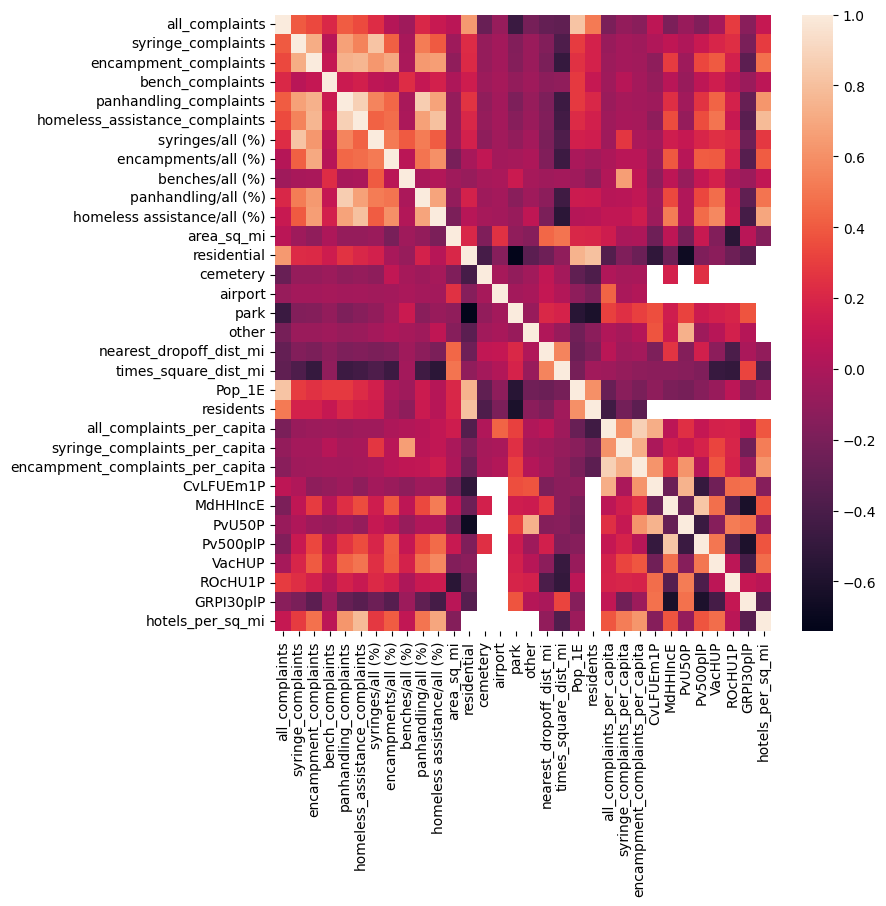

In [202]:
# View the correlation matrix again
fig, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(complaints_by_nta[complaints_by_nta.columns[1:]].corr())

# Modeling

## Linear Regression
I would like to try a linear regression model first, since they are easy to interpret.

In [213]:
# Choose the X and y variables
X_var_names = ['all_complaints', 'encampment_complaints', 'bench_complaints', 'panhandling_complaints',
              'homeless_assistance_complaints', 'nearest_dropoff_dist_mi', 'times_square_dist_mi',
              'Pop_1E', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'hotels_per_sq_mi']

X = complaints_by_nta[X_var_names]

y = complaints_by_nta[['syringe_complaints']]

# Replace NaN with 0 in X - maybe not the best idea
X = X.fillna(0)

# Split the data into train, test, and val sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.2, random_state = 212)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 212)

In [214]:
# Normalize the train, test, and val data based on the train data
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std
X_val_norm = (X_val - X_mean) / X_std

y_mean = y_train.mean()
y_std = y_train.std()
y_train_norm = (y_train - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std
y_val_norm = (y_val - y_mean) / y_std

In [215]:
# Initialize and fit a linear regression model
model = LinearRegression()
model.fit(X_train_norm, y_train_norm)
y_pred_norm = model.predict(X_test_norm)

# Denormalize y_pred_norm
y_pred = y_pred_norm * y_std.values + y_mean.values

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 73.81438301265185
R2: -0.860774273439463


This model is really bad! But no wonder, because a lot of the features are correlated. Therefore, I'm going to try regularization.

In [216]:
# Test whether regularization produces a better model
model = ElasticNet(alpha = 0.5, l1_ratio = 0.5)
model.fit(X_train_norm, y_train_norm)
y_pred_norm = model.predict(X_test_norm)

# Denormalize y_pred_norm
y_pred = y_pred_norm * y_std.values + y_mean.values

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 31.94401747294921
R2: 0.1947286764724917


In [217]:
# Use GridSearchCV to optimize the hyperparameters
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

model = ElasticNet(random_state = 212)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring='r2')
grid_search.fit(X_train_norm, y_train_norm)
print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_norm = best_model.predict(X_test_norm)
y_pred = y_pred_norm * y_std.values + y_mean.values
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

# Print the coefficients
for i, coef in enumerate(best_model.coef_):
  print(f'{X_var_names[i]}, coef = {coef}')

Best hyperparameters: {'alpha': 0.5, 'l1_ratio': 0.3}
Mean Squared Error: 27.47745061544376
R2: 0.30732560351879545
all_complaints, coef = 0.04182664511914862
encampment_complaints, coef = 0.28530148097715613
bench_complaints, coef = -0.0
panhandling_complaints, coef = 0.20692838490320484
homeless_assistance_complaints, coef = 0.0
nearest_dropoff_dist_mi, coef = -0.0
times_square_dist_mi, coef = -0.0
Pop_1E, coef = 0.0
CvLFUEm1P, coef = 0.0
MdHHIncE, coef = 0.0
PvU50P, coef = 0.0
Pv500plP, coef = 0.0
VacHUP, coef = 0.0
ROcHU1P, coef = 0.0
GRPI30plP, coef = 0.0
hotels_per_sq_mi, coef = 0.0


## Linear Regression, Part 2
Including different features.

In [116]:
complaints_by_nta.columns

Index(['NTA2020', 'all_complaints', 'syringe_complaints',
       'encampment_complaints', 'bench_complaints', 'panhandling_complaints',
       'homeless_assistance_complaints', 'syringes/all (%)',
       'encampments/all (%)', 'benches/all (%)', 'panhandling/all (%)',
       'homeless assistance/all (%)', 'area_sq_mi', 'residential', 'cemetery',
       'airport', 'park', 'other', 'nearest_dropoff_dist_mi',
       'times_square_dist_mi', 'Pop_1E', 'residents',
       'all_complaints_per_capita', 'syringe_complaints_per_capita',
       'encampment_complaints_per_capita', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P',
       'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'hotels_per_sq_mi'],
      dtype='object')

In [233]:
# Choose the X and y variables
X_var_names = ['all_complaints', 'encampment_complaints', 'bench_complaints', 'panhandling_complaints',
              'homeless_assistance_complaints', 'area_sq_mi', 'nearest_dropoff_dist_mi', 'times_square_dist_mi',
              'Pop_1E', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'hotels_per_sq_mi',
              'residential', 'cemetery', 'airport', 'park', 'other']

X = complaints_by_nta[X_var_names]

y = complaints_by_nta[['syringe_complaints']]

X = X.fillna(0)

# Split the data into train, test, and val sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.2, random_state = 212)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 212)

In [228]:
# Normalize the train, test, and val data based on the train data
for col in X.columns[:-5]:
  X_train_norm[col] = (X_train[col] - X_train[col].mean()) / X_train[col].std()
  X_test_norm[col] = (X_test[col] - X_train[col].mean()) / X_train[col].std()
  X_val_norm[col] = (X_val[col] - X_train[col].mean()) / X_train[col].std()
for col in X.columns[-5:]:
  X_train_norm[col] = X_train[col]
  X_test_norm[col] = X_test[col]
  X_val_norm[col] = X_val[col]

y_mean = y_train.mean()
y_std = y_train.std()
y_train_norm = (y_train - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std
y_val_norm = (y_val - y_mean) / y_std

In [230]:
# Use GridSearchCV to optimize the hyperparameters
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

model = ElasticNet(random_state = 212)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring='r2')
grid_search.fit(X_train_norm, y_train_norm)
print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_norm = best_model.predict(X_test_norm)
y_pred = y_pred_norm * y_std.values + y_mean.values
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

# Print the coefficients
for i, coef in enumerate(best_model.coef_):
  print(f'{X_var_names[i]}, coef = {coef}')

Best hyperparameters: {'alpha': 0.5, 'l1_ratio': 0.3}
Mean Squared Error: 27.47745061544376
R2: 0.30732560351879545
all_complaints, coef = 0.04182664511914859
encampment_complaints, coef = 0.28530148097715613
bench_complaints, coef = -0.0
panhandling_complaints, coef = 0.20692838490320495
homeless_assistance_complaints, coef = 0.0
area_sq_mi, coef = -0.0
nearest_dropoff_dist_mi, coef = -0.0
times_square_dist_mi, coef = -0.0
Pop_1E, coef = 0.0
CvLFUEm1P, coef = 0.0
MdHHIncE, coef = 0.0
PvU50P, coef = 0.0
Pv500plP, coef = 0.0
VacHUP, coef = 0.0
ROcHU1P, coef = 0.0
GRPI30plP, coef = 0.0
hotels_per_sq_mi, coef = 0.0
residential, coef = 0.0
cemetery, coef = -0.0
airport, coef = -0.0
park, coef = -0.0
other, coef = -0.0


## Random Forest

In [232]:
complaints_by_nta.columns

Index(['NTA2020', 'all_complaints', 'syringe_complaints',
       'encampment_complaints', 'bench_complaints', 'panhandling_complaints',
       'homeless_assistance_complaints', 'syringes/all (%)',
       'encampments/all (%)', 'benches/all (%)', 'panhandling/all (%)',
       'homeless assistance/all (%)', 'area_sq_mi', 'residential', 'cemetery',
       'airport', 'park', 'other', 'nearest_dropoff_dist_mi',
       'times_square_dist_mi', 'Pop_1E', 'residents',
       'all_complaints_per_capita', 'syringe_complaints_per_capita',
       'encampment_complaints_per_capita', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P',
       'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'hotels_per_sq_mi'],
      dtype='object')

In [234]:
# Choose the X and y variables
X_var_names = ['all_complaints', 'encampment_complaints', 'bench_complaints', 'panhandling_complaints',
       'homeless_assistance_complaints', 'area_sq_mi', 'residential', 'cemetery',
       'airport', 'park', 'other', 'nearest_dropoff_dist_mi',
       'times_square_dist_mi', 'Pop_1E', 'residents', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P',
       'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'hotels_per_sq_mi']

X = complaints_by_nta[X_var_names]

y = complaints_by_nta[['syringe_complaints']]

# Split the data into train, test, and val sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.2, random_state = 212)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 212)

In [248]:
# Create a RandomForestRegressor model, using RandomizedSearchCV to optimize the hyperparameters
param_grid = {'n_estimators': randint(100, 500),
              'max_depth': [10, 20, 30, None],
              'max_features': ['sqrt', 'log2', 0.5, 0.8],
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 4)}

model = RandomForestRegressor(random_state = 212)

random_search = RandomizedSearchCV(model, param_distributions = param_grid,
                                   n_iter = 30, cv = 5, scoring = 'r2',
                                   random_state = 212, n_jobs = -1, verbose = 2)

random_search.fit(X_train, y_train.values.flatten())
print("Best hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'max_depth': 30, 'max_features': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 205}
Mean Squared Error: 71.93023249467791
R2: -0.8132770423031872


## Spatial Regression

In [251]:
from pysal.model import spreg

# Choose the X and y variables
X = complaints_by_nta[['all_complaints', 'encampment_complaints', 'bench_complaints', 'panhandling_complaints',
                       'homeless_assistance_complaints', 'nearest_dropoff_dist_mi', 'times_square_dist_mi',
                       'Pop_1E', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'hotels_per_sq_mi']]

y = complaints_by_nta[['syringe_complaints']]

X = X.fillna(0)

# Split the data into train, test, and val sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.2, random_state = 212)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 212)

In [252]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y_train.values,
    # Independent variables
    X_train.values,
    # Dependent variable name
    name_y = 'syringe_complaints',
    # Independent variable name
    name_x = ['all_complaints', 'encampment_complaints', 'bench_complaints', 'panhandling_complaints',
              'homeless_assistance_complaints', 'nearest_dropoff_dist_mi', 'times_square_dist_mi',
              'Pop_1E', 'CvLFUEm1P', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'hotels_per_sq_mi'])

In [253]:
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :syringe_complaints                Number of Observations:         209
Mean dependent var  :      8.7273                Number of Variables   :          17
S.D. dependent var  :     22.5527                Degrees of Freedom    :         192
R-squared           :      0.6164
Adjusted R-squared  :      0.5844
Sum squared residual:     40585.6                F-statistic           :     19.2801
Sigma-square        :     211.383                Prob(F-statistic)     :   7.968e-32
S.E. of regression  :      14.539                Log likelihood        :    -847.151
Sigma-square ML     :     194.190                Akaike info criterion :    1728.303
S.E of regression ML:     13.9352                Schwarz criterion     :    1785.122

------------------------------------------------------

Further reading:
- https://geographicdata.science/book/notebooks/11_regression.html#data-san-diego-airbnb
- https://sustainability-gis.readthedocs.io/en/2022/lessons/L4/spatial_regression.html